# Local Field Potentials (LFPs)

#### **Basic instructions:**
#### 1. **To run code cells**, you can either hit the play button to the left of the cell, or you can select the cell and **press shift-enter**.

#### 2. **The first time** you run this code notebook, you might get a popup asking to choose which version of Python to use (the python "kernel"). **Just hit enter** to choose the base/default version.

#### 3. Make sure you data (.abf) files are in the "data" folder here on the left. You can just copy/paste the files over from where they are saved on your computer.

(If you want to save images, click on the save icon on the left when you hover over the image)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from utils import *
update_plot_defaults()
%load_ext autoreload
%autoreload 2

## 1. Choose the data files you want to analyze

#### Put the .abf files with your recordings in the "data/LFPs" folder

In [2]:
data_folder = "data/8-LFPs"

from glob import glob
data_files = glob(data_folder+"/*.abf")
print(data_folder)
data_files

data/8-LFPs


['data/8-LFPs/50uA.abf',
 'data/8-LFPs/100uA.abf',
 'data/8-LFPs/200uA.abf',
 'data/8-LFPs/250uA.abf',
 'data/8-LFPs/150uA.abf']

Choose which file you want to analyze (copy name from above) and paste the file name here:

You will also need to enter the stimulus currents you used for each recording, since they are not recorded by your acquisition setup

In [49]:
data_files = ['data/8-LFPs/50uA.abf',
            'data/8-LFPs/100uA.abf',
            'data/8-LFPs/150uA.abf',
            'data/8-LFPs/200uA.abf']

stim_amplitudes = [50,100,150,200]

Let's start by loading just one file and plot the raw data:

Trace('50uA.abf')
Number of sweeps: 20
Points per sweep: 8,000
Duration per sweep: 0.800 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage


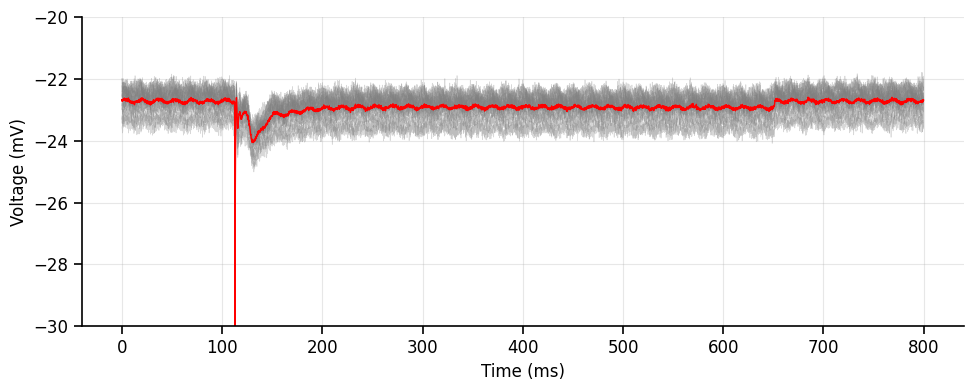

In [50]:
data_file = data_files[0]

traces = Trace.from_axon_file(filename=data_file, 
                              recording_mode="I clamp",
                              load_ttl=False,
                              units=['pA','mV'])
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
%matplotlib inline
ax1 = traces.plot(plot_current=False, plot_voltage=True, sweep='all', time_units=time_units, plot_mean=True, height_ratios=(1,3))
ax1.set_ylim(-30,-20)
plt.show()

Now let's get the average trace for each recording (with different stimulation current) and combine them into a single object

Trace('averaged_traces')
Number of sweeps: 4
Points per sweep: 8,000
Duration per sweep: 0.800 s
Sampling rate: 10000 Hz
Sampling interval: 0.100 ms
Available channels: Current, Voltage


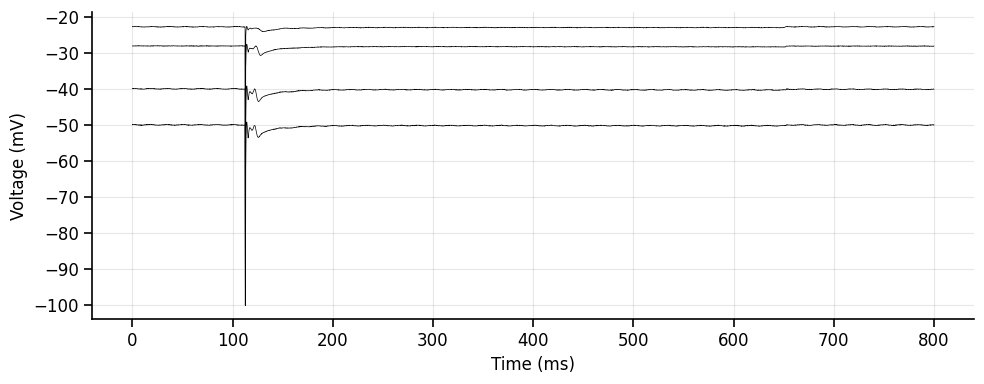

In [51]:
# Lists to store averaged traces
averaged_current_traces = []
averaged_voltage_traces = []

# Loop through each file
for filename in data_files:    
    trace = Trace.from_axon_file(filename=filename, 
                                load_voltage=True,
                                recording_mode="I clamp",
                                load_ttl=False,
                                units=['pA', 'mV'])

    # Average across sweeps
    avg_current = np.mean(trace.current_data, axis=0)[0:10000]
    avg_voltage = np.mean(trace.voltage_data, axis=0)[0:10000]
    averaged_current_traces.append(avg_current)
    averaged_voltage_traces.append(avg_voltage)

# Stack averaged traces into a 2D array and create a new Trace object
combined_current = np.stack(averaged_current_traces, axis=0)
combined_voltage = np.stack(averaged_voltage_traces, axis=0)

traces = Trace(current_data=combined_current,
                sampling_interval=trace.sampling,
                current_unit=trace.current_unit,
                filename='averaged_traces',
                voltage_data=combined_voltage,
                voltage_unit=trace.voltage_unit)
print(traces)

time_units = 'ms' # specify seconds (s), or milliseconds (ms)

# ----------------------------------------------------------------------------------------------------------------
traces.plot(plot_voltage=True, plot_current=False, sweep='all', time_units='ms')
# ax1, ax2 = traces.plot(plot_voltage=True, sweep='all')
plt.show()

## 2. Signal processing

### Optional: apply baseline correction

If your baseline current is not zero, you may need to correct for that to get accurate measurements.

Uncomment this cell block (highlight everything, then cmd+/ on macOS or ctrl+/ on Windows) to run it.

In [52]:
# Change this to True if you want to subtract the baseline from the sweeps.
subtract_baseline = True

BASELINE SUBTRACTED:
Baseline voltages: [-22.6782 -28.0508 -39.8293 -49.8538]


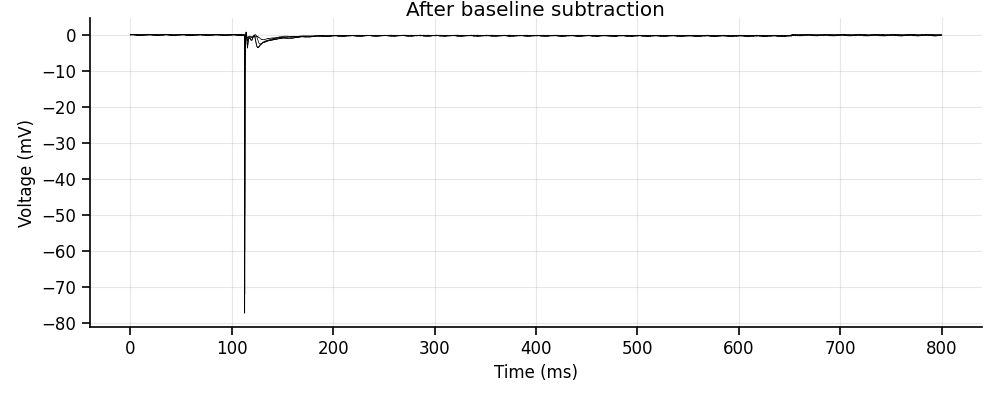

In [53]:
if subtract_baseline:
    traces.subtract_baseline(start_time = 0, 
                             end_time = 0.1, 
                             time_units = 'ms',  # specify seconds (s), or milliseconds (ms)
                             channel = 'voltage')  # Options: 'current', 'voltage', 'all'
    %matplotlib widget
    ax1 = traces.plot(plot_voltage=True, plot_current=False, plot_ttl=False, time_units='ms', sweep='all')
    ax1.set_title('After baseline subtraction', y=0.98)
    plt.show()
else:
    print("BASELINE NOT SUBTRACTED")


### Optional: apply additional highpass/lowpass filtering

Depending in you recording, you may have 50/60 Hz line noise, high-frequency noise, or drift in your recordings.

The goal here is to only remove the noise with minimal distortion of the data, so be careful not to overdo it

In [54]:
# Change this to True if you want to subtract the baseline from the sweeps.
additional_filtering = False

if additional_filtering:
    filtered_traces = traces
    # Step 1: Detrend the data to remove linear or constant trends.
    # filtered_traces = filtered_traces.detrend(detrend_type='linear', num_segments=1)

    # Step 2: Apply a highpass filter to remove low-frequency noise + lowpass to remove high-frequency noise
    filtered_traces = filtered_traces.filter(
        line_freq=60,    # Frequency (Hz) of electrical noise to remove: 50 Hz (in Europe) or 60 Hz (in the US).
        width=0.1,         # Width (Hz) controls the width of frequency bands around the line frequency the filter cuts out.
        highpass=0.01,   # Removes low-frequency drift. Set a value in Hz (e.g. 1 for 1 Hz).
        lowpass=2000,    # Removes high-frequency noise. Set a value in Hz (e.g. 100 for 100 Hz).
        order=4)         # Controls sharpness of the filter. Higher = sharper cutoff.

    %matplotlib widget
    ax = filtered_traces.plot(plot_voltage=False, plot_ttl=False)
    ax.set_title('After filtering', y=0.98)
    plt.show()

Once you are happy with the filter setting, run the next cell to implement them:

In [55]:
if additional_filtering:
    traces=filtered_traces

## 3. Measure the fiber volley amplitude

In [56]:
# Choose setting to automatically detect the stimulus artifact (capacitive transient)
stim_times = traces.get_event_times(threshold=-20, 
                                    polarity='negative', 
                                    time_units=time_units, 
                                    channel='voltage', sweep=0)
# traces.get_ttl_events(threshold=0.5, edge='rising', time_units='ms')
print(f"Stim times: {stim_times} ms")

# Crop the trace after the stim
cropped_traces = traces.crop(timepoint=stim_times[0], window=200, time_units=time_units)

Stim times: [112.7] ms


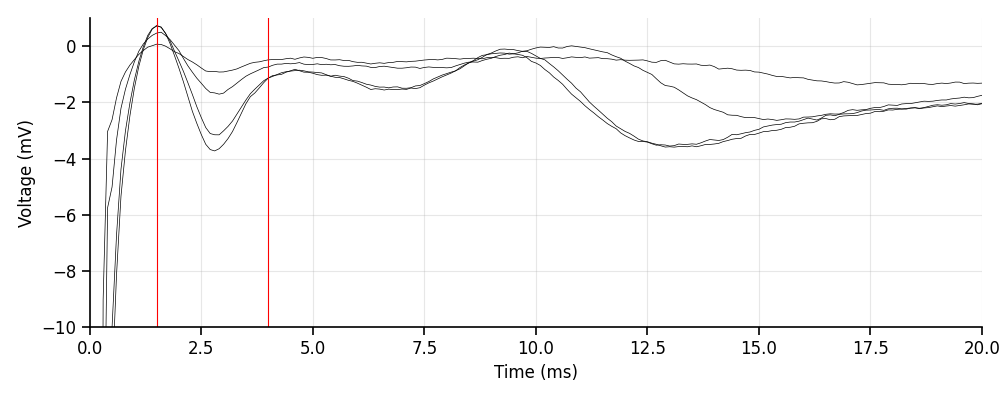

In [57]:
# The start/end time just helps to zoom in on the traces.
start_time = 0
end_time = 20
ylim = (-10,1)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_1 = 1.5
marker_2 = 4

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax = cropped_traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all', marker_1=marker_1, marker_2=marker_2)
ax.set_xlim(start_time,end_time)
ax.set_ylim(ylim)
plt.show()

In [120]:
measurement_type = 'min' # Options: 'mean', 'max', 'min', 'peak'

_, fiber_volley_amplitudes = cropped_traces.get_measurements(start_time=marker_1,
                                                            end_time=marker_2,
                                                            measurement_type=measurement_type,
                                                            time_units=time_units, sweep='all')
fiber_volley_amplitudes = np.abs(fiber_volley_amplitudes)

## 3. Measure the field EPSP

### 3.4. Fit line to get the slope of the fEPSP

First let's define the relevant time window where we want to fit, so we can fit a line to the rising phase

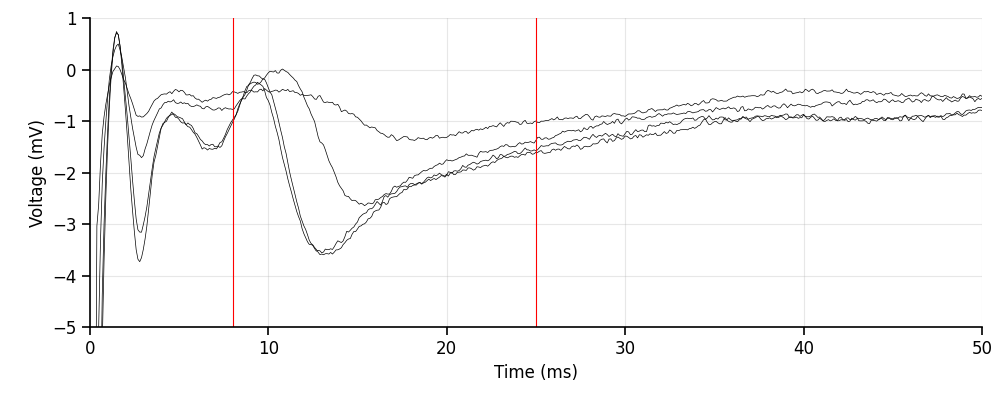

In [121]:
# The start/end time just helps to zoom in on the traces.
start_time = 0
end_time = 50
ylim = (-5,1)

# The markers are important: the will define the window where we actually exctract peak current values from. Set them carefully.
marker_3 = 8
marker_4 = 25

# ----------------------------------------------------------------------------------------------------------------------
%matplotlib widget
ax = cropped_traces.plot(plot_voltage=True, plot_current=False, time_units=time_units, marker_1=marker_3, marker_2=marker_4, sweep='all')
ax.set_xlim(start_time,end_time)
ax.set_ylim(ylim)
plt.show()

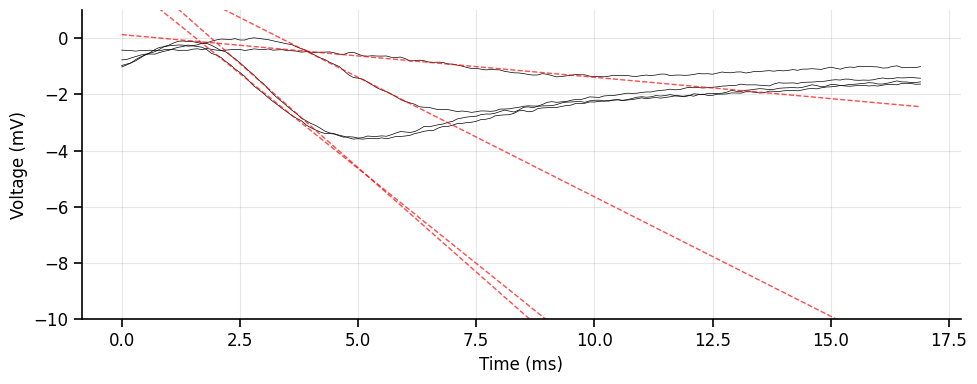

In [127]:
fEPSP_crop = cropped_traces.crop(timepoint=marker_3, timepoint_2=marker_4, time_units=time_units)

%matplotlib inline
ax = fEPSP_crop.plot(plot_voltage=True, plot_current=False, time_units=time_units, sweep='all')

fEPSP_start = np.argmax(fEPSP_crop.voltage_data, axis=1)
fEPSP_end = np.argmin(fEPSP_crop.voltage_data, axis=1)

slopes = []
for i in range(fEPSP_crop.num_sweeps):
    trace = fEPSP_crop.voltage_data[i]
    
    # Get peak indices and values for this trace
    peak_start_idx = fEPSP_start[i]
    peak_end_idx = fEPSP_end[i]
    peak_start_val = trace[peak_start_idx]  # Upper peak value
    peak_end_val = trace[peak_end_idx]      # Lower peak value
    
    # # Calculate 20% and 80% amplitude thresholds
    # amplitude_range = peak_start_val - peak_end_val
    # threshold_20 = peak_start_val - 0.2 * amplitude_range
    # threshold_80 = peak_start_val - 0.8 * amplitude_range
    
    # # Find indices where voltage crosses these thresholds
    # fit_start_idx = np.where(trace <= threshold_20)[0][0]
    # fit_end_idx = np.where(trace <= threshold_80)[0][0]
    
    fit_start_idx = peak_start_idx + 10
    fit_end_idx = peak_end_idx - 10

    # Extract time and voltage for fitting region
    time_fit = fEPSP_crop.time_ms[fit_start_idx:fit_end_idx]
    voltage_fit = trace[fit_start_idx:fit_end_idx]
    
    # Fit linear regression
    from scipy.stats import linregress
    slope, intercept, r_value, p_value, std_err = linregress(time_fit, voltage_fit)
    slopes.append(slope)
    
    # Plot fitted line on original time scale
    fit_line = slope * fEPSP_crop.time_ms + intercept
    ax.plot(fEPSP_crop.time_ms, fit_line, linestyle='--', color='r', alpha=0.7, linewidth=1)

slopes = np.array(slopes)
ax.set_ylim(-10,1)
plt.show()



## 4. Make summary plots

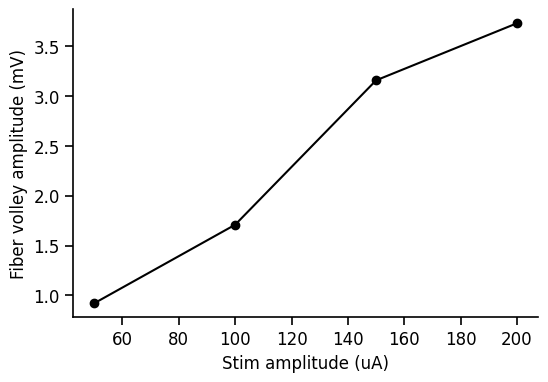

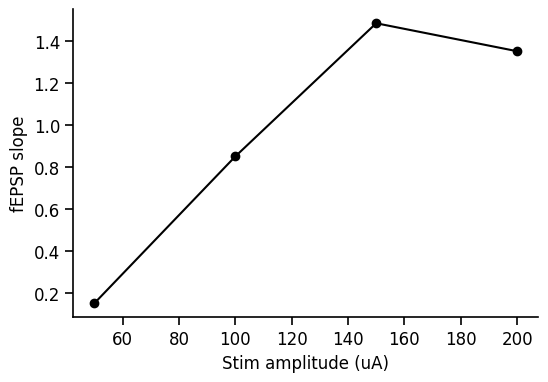

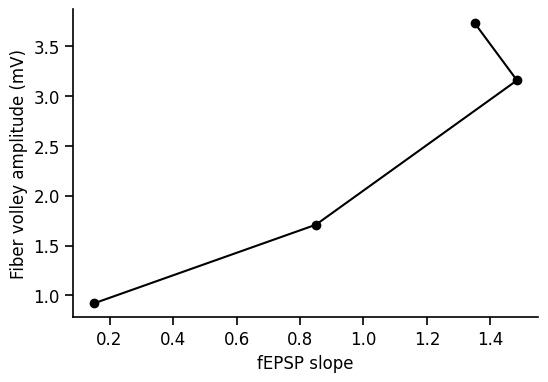

In [132]:
%matplotlib inline
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(stim_amplitudes, fiber_volley_amplitudes, 'o-', color='k')
ax.set_xlabel('Stim amplitude (uA)')
ax.set_ylabel('Fiber volley amplitude (mV)')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(stim_amplitudes, -slopes, 'o-', color='k')
ax.set_xlabel('Stim amplitude (uA)')
ax.set_ylabel('fEPSP slope')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot(-slopes, fiber_volley_amplitudes, 'o-', color='k')
ax.set_ylabel('Fiber volley amplitude (mV)')
ax.set_xlabel('fEPSP slope')
plt.show()